In [1]:
import skimage as sk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
PATH_IMG = '../data/landmarks/aligned/before_4/'

In [3]:
df = pd.read_csv('../data/landmarks/aligned/labels/reformated_8698.csv')

In [4]:
del df['Unnamed: 0']

In [5]:
df_filenames = np.array(df['filename'])
col = df.columns
df_coord = np.array([[int(df[col[i]][j]) for i in range(1,len(col))] for j in range(len(df))])

In [6]:
idx = 0
img = sk.io.imread(PATH_IMG+df_filenames[idx])
coord = df_coord[idx]

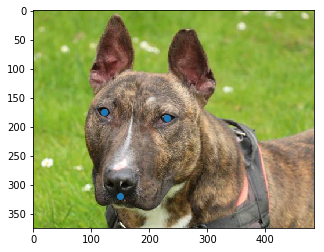

In [7]:
plt.imshow(img)
plt.plot(coord[::2],coord[1::2], 'o')
plt.show()

In [7]:
def clipping(img, coord):
    h, w, c = img.shape
    if h < w:
        bound_min = min(coord[::2])
        bound_max = max(coord[::2])
        if bound_max - bound_min > h:
            print("Shit happens sometimes... {:d} {:d} {:d}".format(bound_max, bound_min, h))
        clip = w - h
        d = bound_min
        D = w - bound_max
        left = int(d*clip/(d+D))
        right = bound_max + D - int(D*clip/(d+D))
        
        coord_add = np.copy(coord)
        coord_add[::2] -= left
        return img[:,left:right,:], np.array(coord_add)
    elif h > w:
        new_coord = []
        for i in range(3):
            new_coord += [coord[2*i+1]] + [coord[2*i]]
            
        img_T = np.transpose(img, axes=(1,0,2))
        img_clipped, coord_add = clipping(img_T, new_coord)
        
        coord_add_T = []
        for i in range(3):
            coord_add_T += [coord_add[2*i+1]] + [coord_add[2*i]]
        
        return np.transpose(img_clipped, axes=(1,0,2)), np.array(coord_add_T)
    else:
        return img, coord

In [8]:
def resize(img, coord, output_shape):
    img_resized = sk.transform.resize(img, output_shape)
    x_ratio = output_shape[0]/img.shape[0]
    y_ratio = output_shape[1]/img.shape[1]
    
    new_coord = np.zeros(6)
    for i in range(3):
        new_coord[2*i] = int(coord[2*i]*x_ratio)
        new_coord[2*i+1] = int(coord[2*i+1]*y_ratio)
    return img_resized, new_coord

(375, 376, 3)


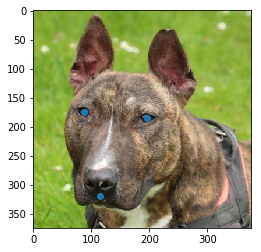

In [10]:
img_clipped, coord_clipped = clipping(img, coord)
print(img_clipped.shape)
plt.imshow(img_clipped)
plt.plot(coord_clipped[::2],coord_clipped[1::2],'o')
plt.show()

(224, 224, 3)


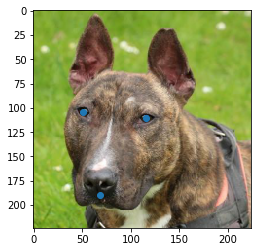

In [11]:
img_resized, coord_resized = resize(img_clipped, coord_clipped, (224,224,3))
print(img_resized.shape)
plt.imshow(img_resized)
plt.plot(coord_resized[::2],coord_resized[1::2],'o')
plt.show()

## New methods with neural networks

In [16]:
# Basic numpy implementation of rotation with quaternions
def angle_axis_quat_np(theta, axis):
    """
    Given an angle and an axis, it returns a quaternion.
    """
    axis = np.array(axis) / np.linalg.norm(axis)
    return np.append([np.cos(theta/2)],np.sin(theta/2) * axis)

def mult_quat_np(q1, q2):
    """
    Quaternion multiplication.
    """
    q3 = np.copy(q1)
    q3[0] = q1[0]*q2[0] - q1[1]*q2[1] - q1[2]*q2[2] - q1[3]*q2[3]
    q3[1] = q1[0]*q2[1] + q1[1]*q2[0] + q1[2]*q2[3] - q1[3]*q2[2]
    q3[2] = q1[0]*q2[2] - q1[1]*q2[3] + q1[2]*q2[0] + q1[3]*q2[1]
    q3[3] = q1[0]*q2[3] + q1[1]*q2[2] - q1[2]*q2[1] + q1[3]*q2[0]
    return q3

def rotate_quat_np(quat, vect):
    """
    Rotate a vector with the rotation defined by a quaternion.
    """
    # Transfrom vect into an quaternion 
    if len(vect)==3:
        vect = np.append([0],vect)
    # Normalize it
    norm_vect = np.linalg.norm(vect)
    if norm_vect:
        vect = vect/norm_vect
    # Normalize the quaternion
    norm_quat = np.linalg.norm(quat)
    if norm_quat:
        quat = quat/norm_quat
    # Computes the conjugate of quat
    quat_ = np.append(quat[0],-quat[1:])
    # The result is given by: quat * vect * quat_
    res = mult_quat_np(quat, mult_quat_np(vect,quat_)) * norm_vect
    #res = np.dot(mat_quat_np(quat), np.dot(mat_quat_np(vect),quat_)) * norm_vect
    return res[1:]

In [14]:
# This code is adapted for Keras/Tensorflow models training
def mat_quat(q):
    """
    Given a quaternion, return its multiplication matrix
    """
    coord=np.array([
        [1,0,0,0],
        [0,-1,0,0],
        [0,0,-1,0],
        [0,0,0,-1],
        [0,1,0,0],
        [1,0,0,0],
        [0,0,0,-1],
        [0,0,1,0],
        [0,0,1,0],
        [0,0,0,1],
        [1,0,0,0],
        [0,-1,0,0],
        [0,0,0,1],
        [0,0,-1,0],
        [0,1,0,0],
        [1,0,0,0]
    ], dtype=np.float32())
    return np.reshape(np.dot(coord,q),(4,4))

def mult_quat(q1, q2):
    """
    Quaternion multiplication.
    q1 is not a list
    """
    return np.dot(q2,np.transpose(mat_quat(q1)))

def rotate_quat(quat, vect):
    """
    Rotate a vector with the rotation defined by a quaternion.
    """
    if len(vect)==3:
        vect = np.append([0],vect)
    # Normalize it
    norm_vect = np.sqrt(np.sum(np.square(vect),axis=-1,keepdims=True))
#     if K.equal(norm_vect,0):
#         return vect
    if norm_vect:
        vect = vect/norm_vect
    # Normalize quat
    norm_quat = np.sqrt(np.sum(np.square(quat),axis=-1,keepdims=True))
    if norm_quat:
        quat = quat / norm_quat
    # Computes the conjugate of quat
    quat_ = np.concatenate((quat[:1],-quat[1:]), axis=-1)
    # The result is given by: quat * vect * quat_
    res = mult_quat(quat, mult_quat(vect,quat_)) * norm_vect
#     print(res.shape)
    return res[1:]

In [46]:
v = [3, 5, 0]
axis = [4, 4, 1]
theta = 1.2 

print(rotate_quat_np(angle_axis_quat_np(theta, axis), v))
print(rotate_quat(angle_axis_quat_np(theta, axis), v))

[2.74911638 4.77180932 1.91629719]
[2.74911638 4.77180932 1.91629719]


### Load the model

In [2]:
A,b = np.load('../output/model/2019.07.01/transform_8.npy', allow_pickle=True)

In [3]:
A,b

(array([[-2.7170989e-01,  1.5300398e-01, -1.3729802e-01, -2.4239977e-01,
          5.6131786e-01,  1.3565560e-02, -5.4057974e-01, -3.0438498e-01],
        [-2.4932659e-01,  6.1709815e-01,  2.0384096e-01, -5.7076162e-01,
          2.5820252e-01,  6.4068604e-01, -3.4571856e-01, -3.8039109e-01],
        [ 3.6703181e-01, -3.5540318e-01, -2.1373703e-01, -1.7523304e-01,
          3.3640495e-01, -1.1292211e-01,  4.0444374e-01,  3.5088646e-01],
        [ 1.2811354e-01,  3.7042162e-01, -2.5829867e-01,  7.2075284e-01,
          2.7979067e-02,  2.6547262e-01,  3.5050452e-02, -1.8263157e-01],
        [ 5.6548056e-04,  5.8828484e-02,  3.3033276e-01,  6.2417233e-01,
          2.7791748e-02,  5.0881155e-02, -4.3204486e-02, -4.1529749e-02],
        [ 1.3910890e-01, -1.0610757e+00,  2.7555810e-02,  3.3871261e-03,
         -3.1195429e-01,  4.6710368e-02,  6.2814605e-01,  5.2846295e-01]],
       dtype=float32),
 array([-0.01956358,  0.05305202,  0.01559347, -0.1411001 ,  0.03508957,
         0.0346183 , 

### Evaluation

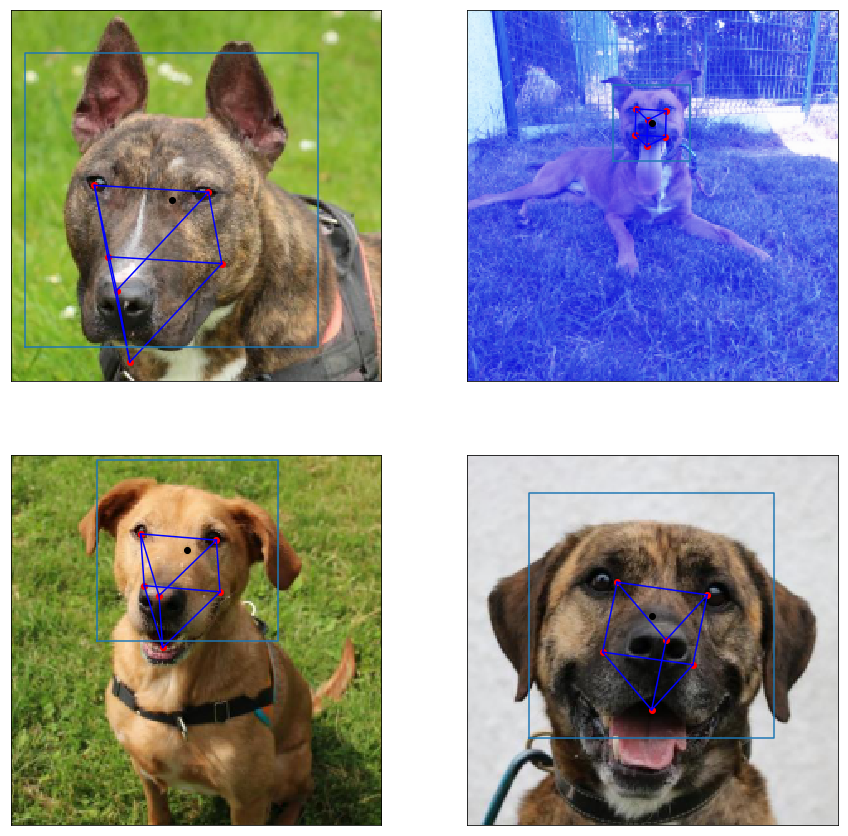

In [50]:
def transform_np(x, model_output):
    q = model_output[:4]
    t = model_output[4:7]
    s = model_output[7]
    
    if np.linalg.norm(x)==0:
        out = t
    else:
        out = s * rotate_quat_np(q,x) + t
    
    return np.dot(out,np.array([[1,0],[0,1],[0,0]]))

def dist(v1,v2):
    return np.sqrt((v1[0]-v2[0])**2+(v1[1]-v2[1])**2)

def mask(q,t,s):
    """
    Transform a mask in 3D space and plot it in 2D.
    """
    c = np.array([
        [0.,0,0],
        [1,0,0],
        [1,0,1],
        [0,0,1],
        [0.5,-1.5,-0.5],
        [0.5,-1.5,0.5]
    ])
    for i in range(len(c)):
        if np.linalg.norm(q)==0:
            c[i] = t
        else:
            q = q/np.linalg.norm(q)
            c[i] = s * rotate_quat_np(q,c[i]) + t
            
    c = np.dot(c,np.array([[1,0],[0,1],[0,0]]))

    for c_e in c:
        plt.plot(c_e[0],c_e[1],'ro')
    
    segments = np.array([
        [c[0],c[1]],
        [c[1],c[2]],
        [c[2],c[3]],
        [c[3],c[0]],
        [c[4],c[5]],
        [c[0],c[4]],
        [c[1],c[4]],
        [c[2],c[5]],
        [c[3],c[5]]
    ])
    segments = np.reshape(segments, (9,4))
    for element in segments:
        plt.plot(element[[0,2]],element[[1,3]],'b')

plt.figure(figsize=(15,15))
start = 51*0
end = 51*4
step = 51
sub = int(np.ceil(np.sqrt((end-start)//step)))
for idx in range(start,end,step):
    plt.subplot(sub,sub,(idx-start)//step+1)
    img = sk.io.imread(PATH_IMG+df_filenames[idx])
    coord = df_coord[idx]
    

    img_clipped, coord_clipped = clipping(img, coord)

    img_resized, coord_resized = resize(img_clipped, coord_clipped, (224,224,3))
    coord_resized_norm = np.sqrt(np.sum(np.square(coord_resized),axis=-1,keepdims=True))
    coord_resized = coord_resized/coord_resized_norm
    
    pred = np.dot(coord_resized,A)+b
    pred = pred * coord_resized_norm
    mask(pred[:4],pred[4:7],pred[7])
    
    coord_resized = coord_resized*coord_resized_norm
    
    plt.imshow(img_resized)
#     plt.plot(coord_resized[::2], coord_resized[1::2],'bo')
#     for x in [[0,0,0,0.],[0,1.,0,0],[0,.5,-1.5,0]]:
#         y = transform(x, pred)
#         plt.plot(y[0],y[1],'go')
#     x = [0,0.5,0,-1.] # Coordinates of the forhead
    x = [0,0.5,0.5,0.8]
    y = transform_np(x, pred)
    plt.plot(y[0],y[1],'ko')
    
    # BBox
    potential_h = [
        dist([coord_resized[0],coord_resized[1]],[coord_resized[2],coord_resized[3]]),
        dist([(coord_resized[0]+coord_resized[2])/2,(coord_resized[1]+coord_resized[3])/2],[coord_resized[4],coord_resized[5]]),
        dist(y,coord_resized[[4,5]])
    ]
    
    h = 2.1 * max(potential_h)
    x1 = max(y[0] - h/2,0)
    x2 = min(y[0] + h/2,224)
    y1 = max(y[1] - h/2,0)
    y2 = min(y[1] + h/2,224)
    plt.plot([x1,x2,x2,x1,x1],[y2,y2,y1,y1,y2])
    plt.xticks([])
    plt.yticks([])
#     plt.savefig('../output/images/bbox/{:d}.png'.format(idx))
plt.show()

### Final version:

In [9]:
def bbox_coord(img, coord):
    A = np.array([[-2.7170989e-01,  1.5300398e-01, -1.3729802e-01, -2.4239977e-01, \
          5.6131786e-01,  1.3565560e-02, -5.4057974e-01, -3.0438498e-01],
        [-2.4932659e-01,  6.1709815e-01,  2.0384096e-01, -5.7076162e-01, \
          2.5820252e-01,  6.4068604e-01, -3.4571856e-01, -3.8039109e-01],
        [ 3.6703181e-01, -3.5540318e-01, -2.1373703e-01, -1.7523304e-01, \
          3.3640495e-01, -1.1292211e-01,  4.0444374e-01,  3.5088646e-01],
        [ 1.2811354e-01,  3.7042162e-01, -2.5829867e-01,  7.2075284e-01, \
          2.7979067e-02,  2.6547262e-01,  3.5050452e-02, -1.8263157e-01],
        [ 5.6548056e-04,  5.8828484e-02,  3.3033276e-01,  6.2417233e-01, \
          2.7791748e-02,  5.0881155e-02, -4.3204486e-02, -4.1529749e-02],
        [ 1.3910890e-01, -1.0610757e+00,  2.7555810e-02,  3.3871261e-03, \
         -3.1195429e-01,  4.6710368e-02,  6.2814605e-01,  5.2846295e-01]], dtype=np.float32)
    b = np.array([-0.01956358,  0.05305202,  0.01559347, -0.1411001 ,  0.03508957, \
         0.0346183 ,  0.        ,  0.02556852], dtype=np.float32)
    
    coord_norm = np.sqrt(np.sum(np.square(coord),axis=-1,keepdims=True))
    coord = coord/coord_norm
    pred = (np.dot(coord,A)+b) * coord_norm
    coord = coord*coord_norm
    
    def mult_quat_np(q1, q2):
        """
        Quaternion multiplication.
        """
        q3 = np.copy(q1)
        q3[0] = q1[0]*q2[0] - q1[1]*q2[1] - q1[2]*q2[2] - q1[3]*q2[3]
        q3[1] = q1[0]*q2[1] + q1[1]*q2[0] + q1[2]*q2[3] - q1[3]*q2[2]
        q3[2] = q1[0]*q2[2] - q1[1]*q2[3] + q1[2]*q2[0] + q1[3]*q2[1]
        q3[3] = q1[0]*q2[3] + q1[1]*q2[2] - q1[2]*q2[1] + q1[3]*q2[0]
        return q3

    def rotate_quat_np(quat, vect):
        """
        Rotate a vector with the rotation defined by a quaternion.
        """
        # Transfrom vect into an quaternion 
        if len(vect)==3:
            vect = np.append([0],vect)
        # Normalize it
        norm_vect = np.linalg.norm(vect)
        if norm_vect:
            vect = vect/norm_vect
        # Normalize the quaternion
        norm_quat = np.linalg.norm(quat)
        if norm_quat:
            quat = quat/norm_quat
        # Computes the conjugate of quat
        quat_ = np.append(quat[0],-quat[1:])
        # The result is given by: quat * vect * quat_
        res = mult_quat_np(quat, mult_quat_np(vect,quat_)) * norm_vect
        #res = np.dot(mat_quat_np(quat), np.dot(mat_quat_np(vect),quat_)) * norm_vect
        return res[1:]

    def transform_np(x, model_output):
        q = model_output[:4]
        t = model_output[4:7]
        s = model_output[7]

        if np.linalg.norm(x)==0:
            out = t
        else:
            out = s * rotate_quat_np(q,x) + t

        return np.dot(out,np.array([[1,0],[0,1],[0,0]]))
    
    x = [0,0.5,0.5,0.8]
    y = transform_np(x, pred)
    
    def dist(v1,v2):
        # Distance between two vectors
        return np.sqrt((v1[0]-v2[0])**2+(v1[1]-v2[1])**2)
    
    potential_h = [
        dist(coord[[0,1]],coord[[2,3]]),
        dist([(coord[0]+coord[2])/2,(coord[1]+coord[3])/2],coord[[4,5]]),
        dist(y,coord[[4,5]])
    ]
    
    h = 2.1 * max(potential_h)
    x1 = int(max(y[0] - h/2,0))
    x2 = int(min(y[0] + h/2,img.shape[1]-1))
    y1 = int(max(y[1] - h/2,0))
    y2 = int(min(y[1] + h/2,img.shape[0]-1))
    
    return (x1,y1,x2,y2)

(24, 0, 58, 33)


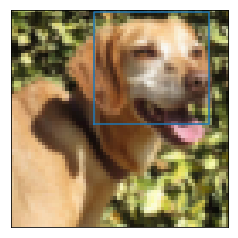

In [11]:
idx = 452
img = sk.io.imread(PATH_IMG+df_filenames[idx])
coord = df_coord[idx]
img_clipped, coord_clipped = clipping(img, coord)
img_resized, coord_resized = resize(img_clipped, coord_clipped, (64,64,3))

plt.imshow(img_resized)
x1,y1,x2,y2=bbox_coord(img_resized,coord_resized)
print((x1,y1,x2,y2))
plt.plot([x1,x2,x2,x1,x1],[y2,y2,y1,y1,y2])
plt.xticks([])
plt.yticks([])
plt.show()

### Study the dataset

In [12]:
def intersection(bbox,img_shape):
    x1,y1,x2,y2=bbox
    return (x2-x1)*(y2-y1)/(img_shape[0]*img_shape[1])

In [14]:
from tqdm import tqdm_notebook

In [19]:
mean = 0
count = 0
for idx in tqdm_notebook(range(0,800,1)):
    count += 1
    img = sk.io.imread(PATH_IMG+df_filenames[idx])
    coord = df_coord[idx]
    img_clipped, coord_clipped = clipping(img, coord)
    img_resized, coord_resized = resize(img_clipped, coord_clipped, (64,64,3))

    bbox=bbox_coord(img_resized,coord_resized)
    mean += intersection(bbox,img_resized.shape)
print(mean/count)

0.27392578125


In [13]:
def IoU(box1,box2):
    x1 = max(box1[0], box2[0])
    x2 = min(box1[2], box2[2])
    y1 = max(box1[1], box2[1])
    y2 = min(box1[3], box2[3])
    intersection = max(x2 - x1, 0) * max(y2 - y1, 0)
    box1_area = (box1[2]-box1[0])*(box1[3]-box1[1])
    box2_area = (box2[2]-box2[0])*(box2[3]-box2[1])
    union = box1_area + box2_area - intersection
    iou = intersection / union
    return iou

In [54]:
def generate_output(img_shape, bbox, window_size, threshold):
    # Return a matrix of size (window_size-2,window_size-2)
    # Full of zero or one. It indicates if the kernel should be
    # active or not. The size of the kernel will always be (3,3).
    
    output = np.zeros((window_size-2,window_size-2))
    ratio = img_shape/window_size
    for i in range(window_size-2):
        for j in range(window_size-2):
            # Computes coordinates of the region of interest in the window
            init_coord = np.array([i,j,i+3,j+3])
            # Transforms it into img_shape coordinates
            trans_coord = init_coord * ratio
            # Computes the IoU of this transform box of the bbox
            # and compares it to a threshold
            if IoU(bbox,trans_coord) > threshold:
                output[i][j] = IoU(bbox,trans_coord)
#                 x1,y1,x2,y2=trans_coord
#                 plt.plot([x1,x2,x2,x1,x1],[y2,y2,y1,y1,y2])
    return output.T

In [59]:
import os
from tqdm import tqdm_notebook
idx = 785
img_shape = (224,224,3)
threshold = 0.6
rejected = 0
# for idx in np.random.randint(len(df_coord),size=10):
for idx in tqdm_notebook(range(len(df_coord))):
    if os.path.exists(PATH_IMG+df_filenames[idx]):
        img = sk.io.imread(PATH_IMG+df_filenames[idx])
        coord = df_coord[idx]
        img_clipped, coord_clipped = clipping(img, coord)
        img_resized, coord_resized = resize(img_clipped, coord_clipped, img_shape)

#         plt.imshow(img_resized)
        bbox=bbox_coord(img_resized,coord_resized)
#         x1,y1,x2,y2=bbox
#         plt.plot([x1,x2,x2,x1,x1],[y2,y2,y1,y1,y2],color='green')
        # For the intermidiate layers
        accepted_filters = []
        for i in range(4,17,2):
            out = generate_output(img_shape[0],bbox,i,threshold)
            if out.any()!=0:
                accepted_filters += [i]
#                 print(i)
        # For the last layer
        if IoU((0,0,img_shape[0],img_shape[1]),bbox)>threshold:
            accepted_filters += [1]
        if len(accepted_filters)==0:
            rejected += 1
print(rejected)
#             print(1)
#             x1,y1,x2,y2=(0,0,img_shape[0]-1,img_shape[1]-1)
#             plt.plot([x1,x2,x2,x1,x1],[y2,y2,y1,y1,y2])
#         plt.show()


500


### Display a transformed cube

In [30]:
def cube(axis,theta,t,s):
    """
    Transform a cube in 3D space and plot it in 2D.
    """
    c = np.array([
        [0.,0,0],
        [1,0,0],
        [1,0,1],
        [0,0,1],
        [0,-1,0],
        [1,-1,0],
        [1,-1,1],
        [0,-1,1]
    ])
    q = angle_axis_quat_np(theta,axis)
    for i in range(len(c)):
        c[i] = s * rotate_quat_np(q,c[i]) + t
        #c[i] = s * np.dot(rotation_matrix_np(axis,theta),c[i]) + t
    z = np.dot(c,np.array([[0],[0],[1]]))
    print(np.array([z[0],z[1],z[4],z[5],(z[4]+z[5])/2]))
    c = np.dot(c,np.array([[1,0],[0,1],[0,0]]))
    print(c)
    for c_e in c:
        plt.plot(c_e[0],c_e[1],'ro')
    plt.plot(c[0][0],c[0][1], 'o', color='pink')
    plt.plot(c[1][0],c[1][1], 'o', color='pink')
    plt.plot((c[4][0]+c[5][0])/2,(c[4][1]+c[5][1])/2, 'o', color='pink')
    segments = np.array([
        [c[0],c[1]],
        [c[1],c[2]],
        [c[2],c[3]],
        [c[3],c[0]],
        [c[4],c[5]],
        [c[5],c[6]],
        [c[6],c[7]],
        [c[7],c[4]],
        [c[0],c[4]],
        [c[1],c[5]],
        [c[2],c[6]],
        [c[3],c[7]]
    ])
    segments = np.reshape(segments, (12,4))
    for element in segments:
        plt.plot(element[[0,2]],element[[1,3]],'b')
    plt.axis('equal')
    plt.show()

[[ 0.        ]
 [-0.05597357]
 [-0.05930413]
 [-0.1152777 ]
 [-0.08729091]]
[[ 0.          0.        ]
 [ 0.99666944  0.05930413]
 [ 1.05597357  0.00333056]
 [ 0.05930413 -0.05597357]
 [ 0.05597357 -0.99666944]
 [ 1.05264302 -0.93736532]
 [ 1.11194714 -0.99333889]
 [ 0.1152777  -1.05264302]]


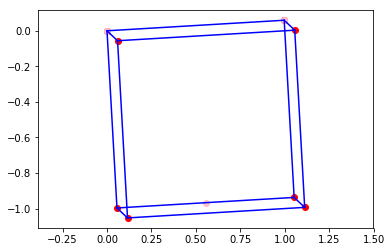

In [37]:
axis = [1,1,1]
theta = 0.1

cube(axis,theta,np.array([0,0,0]),1)